# Autoencoder for Timeseries Denoising

This is an deep convolutional autoencoder for denoising. It's pupose is to denoise timeseries data. This may also help to detect sudden signal changes in the data. I will provide an additional notebook, where the sudden changes in the rotational diffusion behavior are addressed.

## Data Generation


In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_len=784

In [3]:
x_val_noisy=np.zeros(data_len)
noisy_sample=np.zeros(data_len)
pure_sample=np.zeros(data_len)

In [4]:
y_val_noisy_r = []
y_val_pure_r = []
x_val_noisy=np.arange(0,data_len)

for i in range(100000):
    #split=np.random.randint(10,data_len-10)   
    #noisy_sample[0:split]=np.abs(np.random.normal(0,1,split))
    #noisy_sample[split:]=np.abs(5*np.random.normal(0,1,data_len-split))
    pure_sample=np.sin(10*np.pi*x_val_noisy/data_len+np.random.randint(100))
    noisy_sample=pure_sample+np.random.normal(0,1,data_len)
    pure_sample=(pure_sample-np.min(noisy_sample))/(np.max(noisy_sample) - np.min(noisy_sample))
    noisy_sample = (noisy_sample - np.min(noisy_sample)) / (np.max(noisy_sample) - np.min(noisy_sample))
    
    #pure_sample[0:split]=np.mean(noisy_sample[0:split])
    #pure_sample[split:]=np.mean(noisy_sample[split:])
    

    
    tmp_n=np.copy(noisy_sample.reshape(28,28))
    tmp_p=np.copy(pure_sample.reshape(28,28))
    #plt.subplot(10,1,i+1)
    #plt.plot(tmp_n.reshape(10000,1))
    y_val_noisy_r.append(tmp_n)
    y_val_pure_r.append(tmp_p)
    
    
y_val_noisy_r   = np.array(y_val_noisy_r)
y_val_pure_r    = np.array(y_val_pure_r)
noisy_input     = y_val_noisy_r.reshape((y_val_noisy_r.shape[0], y_val_noisy_r.shape[1], y_val_noisy_r.shape[2], 1))
pure_input      = y_val_pure_r.reshape((y_val_pure_r.shape[0], y_val_pure_r.shape[1], y_val_pure_r.shape[2], 1))    

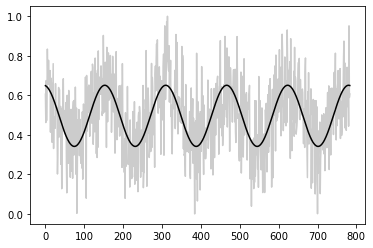

In [5]:
n=np.random.randint(10000)
plt.plot(y_val_pure_r[n].reshape(data_len,1),'k')
plt.plot(y_val_noisy_r[n].reshape(data_len,1),'k',alpha=0.2)

## Autoencoder

This creates an autoencoder. Two convolutional layers for the encoding and two for decoding.

In [394]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.constraints import max_norm
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
from keras.optimizers import RMSprop

from keras.backend.tensorflow_backend import set_session
from keras import backend as K

config = tf.ConfigProto()
config.gpu_options.visible_device_list = "0" # Change to "1" to use 2nd GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.Session(config=config))

In [364]:
# Check available GPUs
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [412]:
# Model configuration
width, height = 28, 28
input_shape = (width, height, 1)
batch_size = 150
no_epochs = 5
train_test_split = 0.3
validation_split = 0.2

In [413]:
# Train/test split
percentage_training = math.floor((1 - train_test_split) * len(noisy_input))
noisy_input, noisy_input_test = noisy_input[:percentage_training], noisy_input[percentage_training:]
pure_input, pure_input_test = pure_input[:percentage_training], pure_input[percentage_training:]

### Encoder/Decoder Definition

In [417]:
model=Sequential()

#encoder
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape,padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')) 
model.add(MaxPooling2D(pool_size=(2, 2)))          
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'))
          
#decoder
model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))          
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))          
model.add(Conv2D(1, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', padding='same'))      

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_169 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_172 (Conv2D)          (None, 7, 7, 128)         147584    
_________________________________________________________________
up_sampling2d_41 (UpSampling (None, 14, 14, 128)       0         
__________

In [418]:
# Compile and fit data
model.compile(optimizer=RMSprop(), loss='mean_squared_error')
model.fit(noisy_input, pure_input,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split)

Train on 56000 samples, validate on 14000 samples
Epoch 1/5
56000/56000 [==============================] - 9s 160us/step - loss: 0.0994 - val_loss: 0.0038
Epoch 2/5
56000/56000 [==============================] - 8s 140us/step - loss: 0.0027 - val_loss: 0.0014
Epoch 3/5
56000/56000 [==============================] - 8s 140us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 4/5
56000/56000 [==============================] - 8s 140us/step - loss: 0.0013 - val_loss: 3.7990e-04
Epoch 5/5
56000/56000 [==============================] - 8s 140us/step - loss: 0.0011 - val_loss: 5.9955e-04


## Reconstruction of the Data

In [435]:
# Generate reconstructions
num_reconstructions = 2000
samples = noisy_input_test[:num_reconstructions]
reconstructions = model.predict(samples)

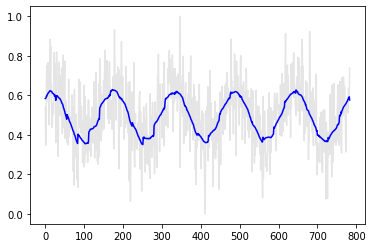

In [446]:
n=np.random.randint(num_reconstructions)
plt.plot(samples[n].reshape(data_len,1),'k',alpha=0.1)
#plt.plot(y_val_noisy_r[n].reshape(data_len,1),'k',alpha=0.2)
plt.plot(reconstructions[n].reshape(data_len,1),'b',alpha=1)